# Group 1 Capstone Project Work
### Make sure to make / checkout your own branch before making changes

# Maddie Hince

In [318]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
                              
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter= '\t')
                            
reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding = 'latin')

movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
                            
movie_budgets_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz",index_col=0)

conn = sqlite3.connect('zippedData/im.db')



# Cat Murad

# Elijah Soba

# Luis Estrada 

# Kilmar Lazo 

# Michael Eugene

In [80]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
                              
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter= '\t')
                            
reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding = 'latin')

movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
                            
movie_budgets_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz",index_col=0)

conn = sqlite3.connect('zippedData/im.db')

In [81]:
df = movie_budgets_df

In [82]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


## Data Cleaning

removing the commas and dollar signs from the columns so that it would easier to do calculations.

In [83]:
df = df.apply(lambda x: x.str.replace(',',''))
df['domestic_gross'] = df['domestic_gross'].fillna(0.0).str.replace('[$,]', '').astype('float')

In [84]:
df['domestic_gross'] = df['domestic_gross'].replace(',', '')
df['domestic_gross'] = df['domestic_gross'].replace('$', '')


In [85]:
df['production_budget'] = df['production_budget'].str.replace(',', '')
df['production_budget'] = df['production_budget'].str.replace('$', '')


In [86]:
df = df.apply(lambda x: x.replace('$',''))
df['production_budget'] = df['production_budget'].fillna(0.0).replace('[$,]', '').astype('float')

In [89]:
df = df.apply(lambda x: x.replace('$',''))
df['worldwide_gross'] = df['worldwide_gross'].fillna(0.0).replace('[$,]', '').astype('float')

In [88]:
df['worldwide_gross'] = df['worldwide_gross'].str.replace(',', '')
df['worldwide_gross'] = df['worldwide_gross'].str.replace('$', '')


## Data exploration 

Taking a look at the top 15 movies with the highest production budget

In [90]:
sorted_df=df.sort_values(by ='production_budget', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2.776345e+09
2,May 20 2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,Jun 7 2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,May 1 2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,Dec 15 2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [91]:
my_fn =lambda x:float(x.replace(',',''))

Looking at the movies with the highest domestic_ gross

In [92]:
sorted_df=df.sort_values(by ='domestic_gross', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2.776345e+09
42,Feb 16 2018,Black Panther,200000000.0,700059566.0,1.348258e+09
7,Apr 27 2018,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09
43,Dec 19 1997,Titanic,200000000.0,659363944.0,2.208208e+09


Looking the movies with highest worldwide_gross

In [93]:
sorted_df=df.sort_values(by ='worldwide_gross', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,Dec 18 2009,Avatar,425000000.0,760507625.0,2.776345e+09
43,Dec 19 1997,Titanic,200000000.0,659363944.0,2.208208e+09
6,Dec 18 2015,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09
7,Apr 27 2018,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09
34,Jun 12 2015,Jurassic World,215000000.0,652270625.0,1.648855e+09


In [94]:
sorted_df=df.sort_values(by ='worldwide_gross', ascending = False).mean()
sorted_df.head(10)

production_budget    3.158776e+07
domestic_gross       4.187333e+07
worldwide_gross      9.148746e+07
dtype: float64

In [95]:
my_fn =lambda x:float(x)


Ordering movies by the year 

In [96]:
df['release_date'] = pd.to_datetime(df['release_date']).dt.year
df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009,Avatar,425000000.0,760507625.0,2.776345e+09
2,2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [97]:
sorted_df=df.sort_values(by ='release_date', ascending = False)
sorted_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
95,2020,Moonfall,150000000.0,0.0,0.0
36,2020,Call of the Wild,82000000.0,0.0,0.0
6,2020,Hannibal the Conqueror,50000000.0,0.0,0.0
30,2019,Unhinged,29000000.0,0.0,0.0
71,2019,PLAYMOBIL,75000000.0,0.0,0.0


Mean of the top 300 grossing movies worldwide

In [98]:
sorted_df.sort_values(by = 'worldwide_gross', ascending=False)['worldwide_gross'][:300].mean()

685175373.19

Mean of the top 300 grossing movies production budget.

In [74]:
sorted_df.sort_values(by = 'worldwide_gross', ascending=False)['production_budget'][:300].mean()

134329408.73

## Visualization 

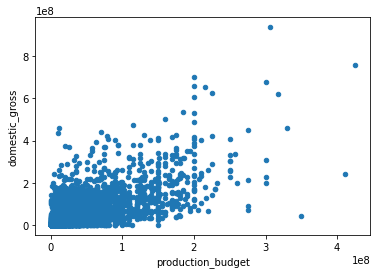

In [74]:
df.plot.scatter(x = 'production_budget', y = 'domestic_gross', s = 20);


Looking at the correlation between budget and gross

In [99]:
np.corrcoef(sorted_df['production_budget'], sorted_df['worldwide_gross'])[0][1]

0.7483059765694757

Top 30 years that producted the most movies.

<AxesSubplot:>

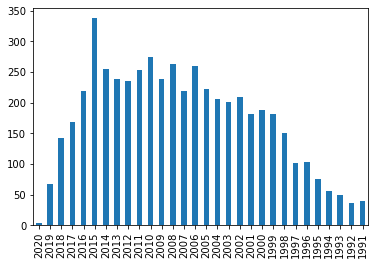

In [100]:
sorted_df['release_date'].value_counts().sort_index(ascending=False)[:30].plot.bar()

Looking at how many movies came per year since 2000

In [101]:
sorted_df = sorted_df[sorted_df['release_date'] > 2000]

In [103]:
sorted_df['release_date'].value_counts()
df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009,Avatar,425000000.0,760507625.0,2.776345e+09
2,2011,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
3,2019,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
4,2015,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
5,2017,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


Taking a look at meadian movie gross 

<AxesSubplot:xlabel='release_date', ylabel='worldwide_gross'>

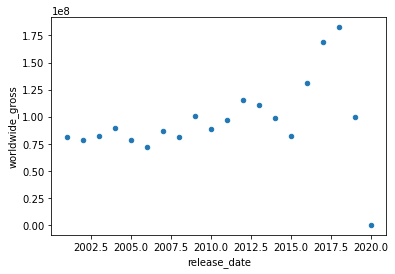

In [104]:
sorted_df.groupby('release_date').mean().reset_index().plot.scatter('release_date', 'worldwide_gross')